In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns

# Global style
sns.set_theme(context="paper", style="whitegrid")
mpl.rcParams.update({
    "figure.figsize": (6, 4),          # default size
    "axes.grid": True,
    "grid.color": "grey",
    "grid.alpha": 0.5,
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    "lines.linewidth": 2.0,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

# Optional helpers for quick size switches and reference lines
def fig_small():
    mpl.rcParams["figure.figsize"] = (6, 4)

def fig_wide():
    mpl.rcParams["figure.figsize"] = (12, 4)

def ref_line(ax, kind="diag", **kwargs):
    """Draw common reference lines with consistent styling."""
    style = dict(color="black", linestyle="--", linewidth=1.2)
    style.update(kwargs)
    if kind == "diag":
        ax.plot([0, 1], [0, 1], **style, transform=ax.transAxes)  # y=x in axes coords
    elif kind == "v":
        ax.axvline(0, **style)
    elif kind == "h":
        ax.axhline(0, **style)
    return ax

# Example use per plot:
# fig_small()   # or fig_wide()
# ax = df.plot(...)
# ref_line(ax, "diag")  # or "v", "h"
# plt.show()


In [3]:
df_cleaned = pd.read_csv('/home/canelo/uncertainty_quantification/datasets/craigslist_cleaned.csv')
display(df_cleaned.head())
print(df_cleaned.shape)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,id
0,hudson valley,18997,2013,dodge,durango,excellent,6 cylinders,gas,96475,clean,automatic,4wd,suv,black,ny,42.598,-73.708,2021-04-04 07:00:00+00:00,2021-04-04 07:00:25,Y2021Q2,2021,0
1,kenosha-racine,119,2013,dodge,dart,excellent,4 cylinders,gas,71800,not_available,automatic,not_available,sedan,not_available,wi,42.596,-87.879,2021-04-04 07:03:00+00:00,2021-04-04 07:03:15,Y2021Q2,2021,1
2,richmond,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,automatic,not_available,not_available,not_available,va,33.821,-84.355,2021-04-04 07:08:00+00:00,2021-04-04 07:08:37,Y2021Q2,2021,2
3,western slope,38900,2013,not_available,grand caravan,not_available,6 cylinders,not_available,19,clean,automatic,fwd,not_available,black,co,39.674,-104.999,2021-04-04 07:10:00+00:00,2021-04-04 07:10:45,Y2021Q2,2021,3
4,richmond,11750,2013,honda,civic lx,good,4 cylinders,gas,55000,clean,automatic,fwd,not_available,silver,va,37.523,-77.445,2021-04-04 07:20:00+00:00,2021-04-04 07:20:50,Y2021Q2,2021,4


(331468, 22)


In [4]:
df_train = pd.read_csv('/home/canelo/uncertainty_quantification/final_models/base_model/evals/base_point_s3_20251122-210436_284574/train_preds.csv')
df_val = pd.read_csv('/home/canelo/uncertainty_quantification/final_models/base_model/evals/base_point_s3_20251122-210436_284574/val_preds.csv')
df_test = pd.read_csv('/home/canelo/uncertainty_quantification/final_models/base_model/evals/base_point_s3_20251122-210436_284574/test_preds.csv')

print('Train:', df_train.shape)
print('Val:', df_val.shape)
print('Test:', df_test.shape)

Train: (232028, 3)
Val: (33147, 3)
Test: (66293, 3)


In [5]:
df_train.head()

,id,y_true,y_pred
0,285611,37995.000,37187.832
1,140471,17995.000,18668.957
2,48138,950.000,1458.408
3,46357,13999.000,15339.973
4,25842,27990.000,28560.141


In [6]:
df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

331468

In [7]:
# Combine split IDs + y_pred with their origin, check for overlap, then merge into df_cleaned
split_preds = pd.concat(
    [
        df_train[["id", "y_pred"]].drop_duplicates(subset="id").assign(set="train"),
        df_val[["id", "y_pred"]].drop_duplicates(subset="id").assign(set="val"),
        df_test[["id", "y_pred"]].drop_duplicates(subset="id").assign(set="test"),
    ],
    ignore_index=True,
)

# Detect IDs that appear in more than one split
dupe_ids = split_preds[split_preds.duplicated("id", keep=False)]
if not dupe_ids.empty:
    print("Warning: IDs found in multiple splits:\n", dupe_ids.sort_values("id"))

# Keep one row per id in df_cleaned and merge to tag each row with its split + y_pred
df_cleaned_unique = df_cleaned.drop_duplicates(subset="id")
df_cleaned_with_set = df_cleaned_unique.merge(
    split_preds, on="id", how="inner", validate="one_to_one"
)
display(df_cleaned_with_set.head())
print(df_cleaned_with_set.shape)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,id,y_pred,set
0,hudson valley,18997,2013,dodge,durango,excellent,6 cylinders,gas,96475,clean,automatic,4wd,suv,black,ny,42.598,-73.708,2021-04-04 07:00:00+00:00,2021-04-04 07:00:25,Y2021Q2,2021,0,1569.217,train
1,kenosha-racine,119,2013,dodge,dart,excellent,4 cylinders,gas,71800,not_available,automatic,not_available,sedan,not_available,wi,42.596,-87.879,2021-04-04 07:03:00+00:00,2021-04-04 07:03:15,Y2021Q2,2021,1,517.678,train
2,richmond,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,automatic,not_available,not_available,not_available,va,33.821,-84.355,2021-04-04 07:08:00+00:00,2021-04-04 07:08:37,Y2021Q2,2021,2,4613.891,train
3,western slope,38900,2013,not_available,grand caravan,not_available,6 cylinders,not_available,19,clean,automatic,fwd,not_available,black,co,39.674,-104.999,2021-04-04 07:10:00+00:00,2021-04-04 07:10:45,Y2021Q2,2021,3,39413.629,val
4,richmond,11750,2013,honda,civic lx,good,4 cylinders,gas,55000,clean,automatic,fwd,not_available,silver,va,37.523,-77.445,2021-04-04 07:20:00+00:00,2021-04-04 07:20:50,Y2021Q2,2021,4,13395.994,train


(331468, 24)


In [8]:
df_cleaned_with_set.drop(columns='posting_date', inplace=True)
df_cleaned_with_set.rename(columns={'posting_date_formatted' : 'posting_date'}, inplace=True)
display(df_cleaned_with_set.head())
print(df_cleaned_with_set.shape)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,quarter,posting_year,id,y_pred,set
0,hudson valley,18997,2013,dodge,durango,excellent,6 cylinders,gas,96475,clean,automatic,4wd,suv,black,ny,42.598,-73.708,2021-04-04 07:00:25,Y2021Q2,2021,0,1569.217,train
1,kenosha-racine,119,2013,dodge,dart,excellent,4 cylinders,gas,71800,not_available,automatic,not_available,sedan,not_available,wi,42.596,-87.879,2021-04-04 07:03:15,Y2021Q2,2021,1,517.678,train
2,richmond,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,automatic,not_available,not_available,not_available,va,33.821,-84.355,2021-04-04 07:08:37,Y2021Q2,2021,2,4613.891,train
3,western slope,38900,2013,not_available,grand caravan,not_available,6 cylinders,not_available,19,clean,automatic,fwd,not_available,black,co,39.674,-104.999,2021-04-04 07:10:45,Y2021Q2,2021,3,39413.629,val
4,richmond,11750,2013,honda,civic lx,good,4 cylinders,gas,55000,clean,automatic,fwd,not_available,silver,va,37.523,-77.445,2021-04-04 07:20:50,Y2021Q2,2021,4,13395.994,train


(331468, 23)


In [9]:
df = df_cleaned_with_set.copy()

df['error'] = df['price'] - df['y_pred']
df['abs_error'] = (df['price'] - df['y_pred']).abs()

In [10]:
print(df.columns)
print(df.head())

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state', 'lat', 'long', 'posting_date',
       'quarter', 'posting_year', 'id', 'y_pred', 'set', 'error', 'abs_error'],
      dtype='object')
           region  price  year   manufacturer          model      condition  \
0   hudson valley  18997  2013          dodge        durango      excellent   
1  kenosha-racine    119  2013          dodge           dart      excellent   
2        richmond  18937  2011  not_available       forde350  not_available   
3   western slope  38900  2013  not_available  grand caravan  not_available   
4        richmond  11750  2013          honda       civic lx           good   

     cylinders           fuel  odometer   title_status transmission  \
0  6 cylinders            gas     96475          clean    automatic   
1  4 cylinders            gas     71800  not_available    

## Global error distribution

=== Original-space residual summary (val+test) ===
       error_orig  abs_error_orig
count   99440.000       99440.000
mean       51.575        2208.096
std      4207.730        3582.167
min    -69684.961           0.007
50%       -12.173        1109.050
90%      3079.730        5080.026
95%      5204.373        7827.632
99%     13372.018       17886.817
max     72578.950       72578.950

=== Log-space residual summary (val+test, log1p(price)) ===
       resid_log
count  99440.000
mean      -0.067
std        0.663
min      -10.275
50%       -0.001
90%        0.219
95%        0.355
99%        0.854
max        7.016


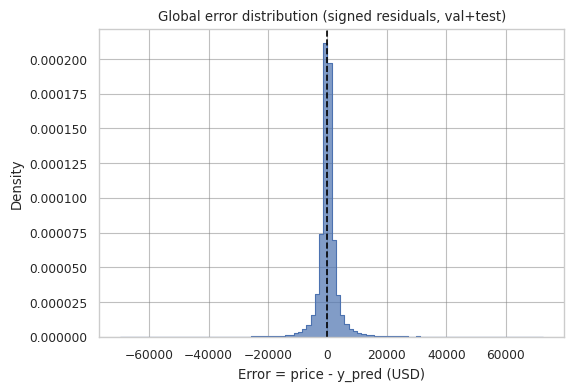

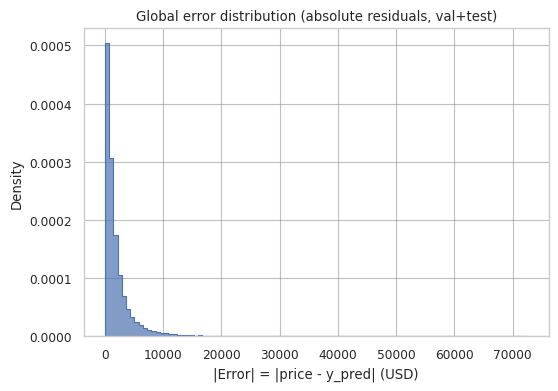

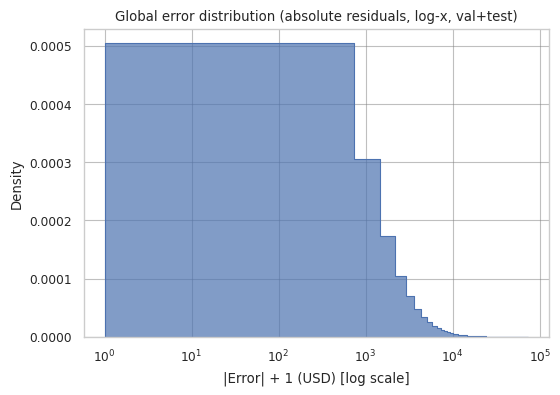

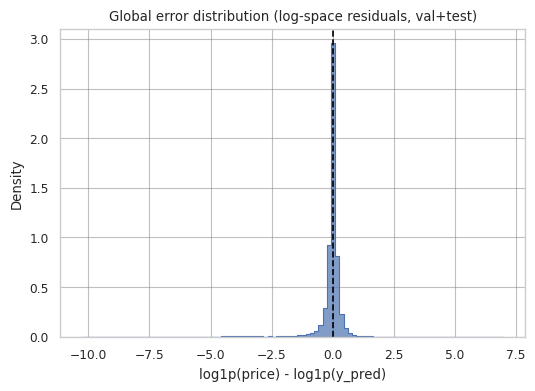

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# 0) Config: which splits to analyze, and whether to look at log-space
# ---------------------------------------------------------------------
EVAL_SETS = ["val", "test"]   # typically we care about generalization, not train
USE_LOG_SPACE = True          # set to False if you only want original-space

# ---------------------------------------------------------------------
# 1) Subset to evaluation data and (re)compute residuals
# ---------------------------------------------------------------------
df_eval = df[df["set"].isin(EVAL_SETS)].copy()

# (Re)compute residuals to be explicit and robust
df_eval["error_orig"] = df_eval["price"] - df_eval["y_pred"]
df_eval["abs_error_orig"] = df_eval["error_orig"].abs()

# Optional: sanity check against existing columns (if you want)
# If you expect them to match exactly, you can uncomment:
# assert np.allclose(df_eval["error_orig"], df_eval["error"], atol=1e-6)
# assert np.allclose(df_eval["abs_error_orig"], df_eval["abs_error"], atol=1e-6)

# ---------------------------------------------------------------------
# 2) Optional: log-space residuals (log1p transform)
# ---------------------------------------------------------------------
if USE_LOG_SPACE:
    # Guard: y_pred should be non-negative for log1p; clip just in case
    df_eval["price_log"] = np.log1p(df_eval["price"])
    df_eval["y_pred_log"] = np.log1p(np.clip(df_eval["y_pred"], a_min=0, a_max=None))
    df_eval["resid_log"] = df_eval["price_log"] - df_eval["y_pred_log"]

# ---------------------------------------------------------------------
# 3) Summary statistics for residuals (original space)
# ---------------------------------------------------------------------
summary_orig = df_eval[["error_orig", "abs_error_orig"]].describe(
    percentiles=[0.5, 0.9, 0.95, 0.99]
)
print("=== Original-space residual summary (val+test) ===")
print(summary_orig)

if USE_LOG_SPACE:
    summary_log = df_eval[["resid_log"]].describe(
        percentiles=[0.5, 0.9, 0.95, 0.99]
    )
    print("\n=== Log-space residual summary (val+test, log1p(price)) ===")
    print(summary_log)

# ---------------------------------------------------------------------
# 4) Plots: residual distribution in original space
# ---------------------------------------------------------------------

# 4a) Signed errors: how predictions deviate from true price
fig_small()
ax = sns.histplot(
    data=df_eval,
    x="error_orig",
    bins=100,
    stat="density",
    element="step",
    fill=True,
    alpha=0.7,
)
ref_line(ax, kind="v")  # vertical line at 0
ax.set_xlabel("Error = price - y_pred (USD)")
ax.set_ylabel("Density")
ax.set_title("Global error distribution (signed residuals, val+test)")
plt.show()

# 4b) Absolute errors: how big the mistakes are (ignoring direction)
fig_small()
ax = sns.histplot(
    data=df_eval,
    x="abs_error_orig",
    bins=100,
    stat="density",
    element="step",
    fill=True,
    alpha=0.7,
)
ax.set_xlabel("|Error| = |price - y_pred| (USD)")
ax.set_ylabel("Density")
ax.set_title("Global error distribution (absolute residuals, val+test)")
plt.show()

# 4c) Same absolute errors but with a log x-axis to highlight tails
fig_small()
# Add a small constant so zeros don't break the log scale
ax = sns.histplot(
    data=df_eval.assign(abs_error_shifted=df_eval["abs_error_orig"] + 1.0),
    x="abs_error_shifted",
    bins=100,
    stat="density",
    element="step",
    fill=True,
    alpha=0.7,
)
ax.set_xscale("log")
ax.set_xlabel("|Error| + 1 (USD) [log scale]")
ax.set_ylabel("Density")
ax.set_title("Global error distribution (absolute residuals, log-x, val+test)")
plt.show()

# ---------------------------------------------------------------------
# 5) Plots: residual distribution in log space (optional)
# ---------------------------------------------------------------------
if USE_LOG_SPACE:
    fig_small()
    ax = sns.histplot(
        data=df_eval,
        x="resid_log",
        bins=100,
        stat="density",
        element="step",
        fill=True,
        alpha=0.7,
    )
    ref_line(ax, kind="v")  # vertical line at 0
    ax.set_xlabel("log1p(price) - log1p(y_pred)")
    ax.set_ylabel("Density")
    ax.set_title("Global error distribution (log-space residuals, val+test)")
    plt.show()


#### How to interpret this analysis

This analysis describes how the point model behaves on validation and test data by looking at the distribution of residuals:

- **Signed residuals** (`price - y_pred`) show whether the model is globally biased (systematic over-/underpricing) and how symmetric the errors are.  
- **Absolute residuals** (`|price - y_pred|`) describe the typical magnitude of mistakes and the frequency of very large errors (tail behaviour).  
- **Log-space residuals** (`log1p(price) - log1p(y_pred)`) show how well a simple Gaussian/Laplace noise model in log-price space fits the central bulk of errors.  
- **Heavy tails or extreme outliers** indicate regimes where the model is unreliable and where good uncertainty estimates are especially important.

#### Summary of results and link to the UQ goal

- The model is **essentially unbiased globally**: mean error ≈ +50 USD, median ≈ –10 USD, with a narrow peak of signed residuals around zero.  
- **Typical errors are moderate** (median `|error|` ≈ 1.1k USD; 90% ≤ ~5.1k USD), but the distribution is **strongly heavy-tailed**, with ~1% of cases above ~17.9k USD and extremes around 70k USD.  
- In `log1p(price)` space, residuals are **tightly concentrated and nearly symmetric** for the central 90–95% of data, supporting Gaussian/Laplace-style likelihoods, but still show **rare extreme outliers**.  

Together, this motivates the UQ work: probabilistic methods should model the well-behaved central noise in log space and assign high uncertainty to the rare, extreme-error cases so they can be identified and managed.

## Heteroscedasticity

Test rows used for heteroscedasticity analysis: 66,293


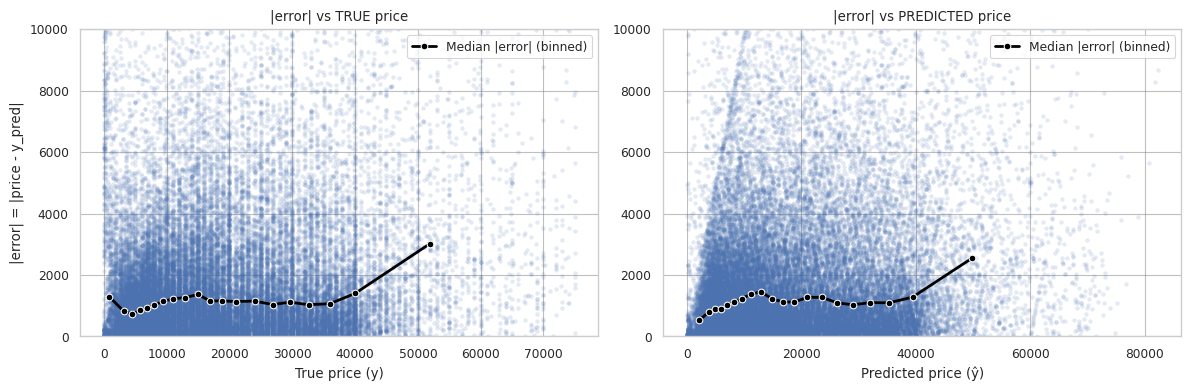

In [12]:
# === Cell: Heteroscedasticity — |error| vs price and vs y_pred ===
#
# What this cell does
# -------------------
# • Uses the TEST set only.
# • Plots |error| vs TRUE price and vs PREDICTED price (scatter).
# • Overlays a smooth trend: median |error| per quantile-bin of price / y_pred.
# • Helps answer: "Does error magnitude grow with the scale of the target?"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assumes:
# - df is already in memory with columns: ['price', 'y_pred', 'abs_error', 'set']
# - Seaborn theme + mpl.rcParams + fig_small/fig_wide/ref_line are already defined.

# -------------------------------------------------------------
# 1) Restrict to TEST set and clean basic NaNs / infinities
# -------------------------------------------------------------
df_test = (
    df.loc[df["set"] == "test", ["price", "y_pred", "abs_error"]]
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
      .copy()
)

print(f"Test rows used for heteroscedasticity analysis: {len(df_test):,}")

if df_test.empty:
    raise ValueError("No valid test rows available for heteroscedasticity analysis.")

# -------------------------------------------------------------
# 2) Optional: downsample for scatter (visual clarity)
# -------------------------------------------------------------
MAX_SCATTER_POINTS = 40_000
if len(df_test) > MAX_SCATTER_POINTS:
    df_scatter = df_test.sample(n=MAX_SCATTER_POINTS, random_state=0)
else:
    df_scatter = df_test

# -------------------------------------------------------------
# 3) Helper: quantile-binned median |error| vs price/prediction
# -------------------------------------------------------------
def binned_error_stats(frame: pd.DataFrame, x_col: str, n_bins: int = 20) -> pd.DataFrame:
    """
    Compute median |error| per quantile-bin of x_col.
    Returns a small dataframe with:
      - x_mid: median x within the bin (for plotting on x-axis)
      - mae: mean |error| in the bin
      - med_abs_error: median |error| in the bin
      - n: number of points in the bin
    """
    df_valid = frame[[x_col, "abs_error"]].copy()
    df_valid = df_valid.replace([np.inf, -np.inf], np.nan).dropna()
    if df_valid.empty:
        return pd.DataFrame(columns=["x_mid", "mae", "med_abs_error", "n"])

    # Quantile-based bins so each bin has similar number of points
    q_bins = pd.qcut(df_valid[x_col], q=n_bins, duplicates="drop")
    stats = (
        df_valid
        .groupby(q_bins, observed=True)
        .agg(
            x_mid=(x_col, "median"),
            mae=("abs_error", "mean"),
            med_abs_error=("abs_error", "median"),
            n=("abs_error", "size"),
        )
        .reset_index(drop=True)
    )
    return stats

stats_true = binned_error_stats(df_test, "price", n_bins=20)
stats_pred = binned_error_stats(df_test, "y_pred", n_bins=20)

# -------------------------------------------------------------
# 4) Plot: |error| vs TRUE price and vs PREDICTED price
# -------------------------------------------------------------
fig_wide()
fig, axes = plt.subplots(1, 2, sharey=False)

# --- (a) |error| vs TRUE price ---
ax = axes[0]
axes[0].set_ylim(0, 10_000),
sns.scatterplot(
    data=df_scatter,
    x="price",
    y="abs_error",
    alpha=0.15,
    s=10,
    linewidth=0,
    ax=ax,
)
sns.lineplot(
    data=stats_true,
    x="x_mid",
    y="med_abs_error",
    marker="o",
    color='black',
    ax=ax,
    label="Median |error| (binned)",
)
ax.set_xlabel("True price (y)")
ax.set_ylabel("|error| = |price - y_pred|")
ax.set_title("|error| vs TRUE price")
ax.legend()

# --- (b) |error| vs PREDICTED price ---
ax = axes[1]
axes[1].set_ylim(0, 10_000),
sns.scatterplot(
    data=df_scatter,
    x="y_pred",
    y="abs_error",
    alpha=0.15,
    s=10,
    linewidth=0,
    ax=ax,
)
sns.lineplot(
    data=stats_pred,
    x="x_mid",
    y="med_abs_error",
    marker="o",
    color='black',
    ax=ax,
    label="Median |error| (binned)",
)
ax.set_xlabel("Predicted price (ŷ)")
ax.set_ylabel("")  # shared with left plot
ax.set_title("|error| vs PREDICTED price")
ax.legend()

plt.tight_layout()
plt.show()


#### Heteroscedasticity analysis: \|error\| vs price / prediction

**How the analysis is performed**

- Use only the test set and the columns `price`, `y_pred`, and `abs_error`.
- Create two scatter plots: \|error\| vs **true price** and vs **predicted price**.
- For each x-axis, split observations into quantile bins and compute the **median \|error\|** per bin; plot this as a black line to show the typical error magnitude as price / prediction increases.

**What the results suggest and why it matters for UQ**

- Across the mid price/prediction range, median \|error\| is roughly constant (~1–1.5k), but it **increases clearly for very cheap and especially very expensive cars** (and high predictions), reaching around 2–3k.
- This pattern shows **heteroscedasticity in absolute terms**: the error variance depends on the scale of the target/prediction.
- This empirically motivates modelling **aleatoric uncertainty** with **heteroscedastic** methods (e.g. Gaussian/Laplace heads or flows with input-dependent σ) and later checking whether the learned aleatoric signal indeed grows in the same high-error regions highlighted by this plot.


### Residuals vs key features (structured noise vs missing signal)

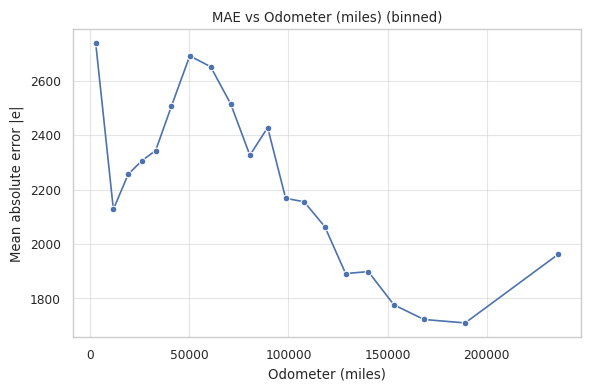

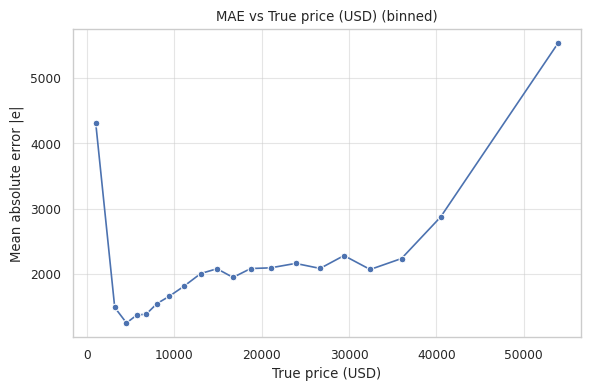

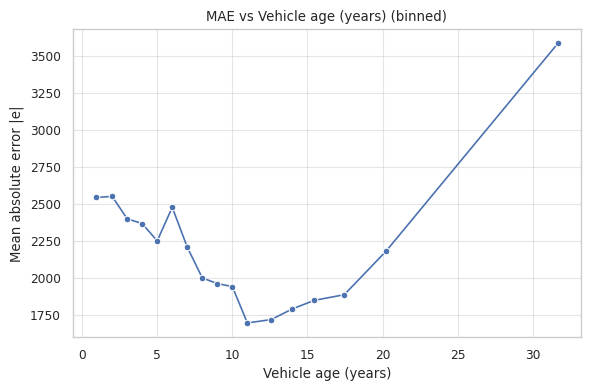

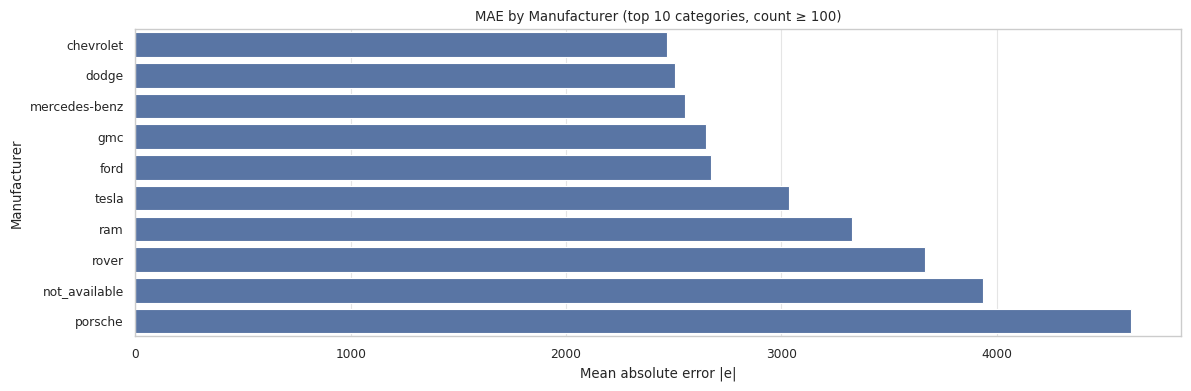

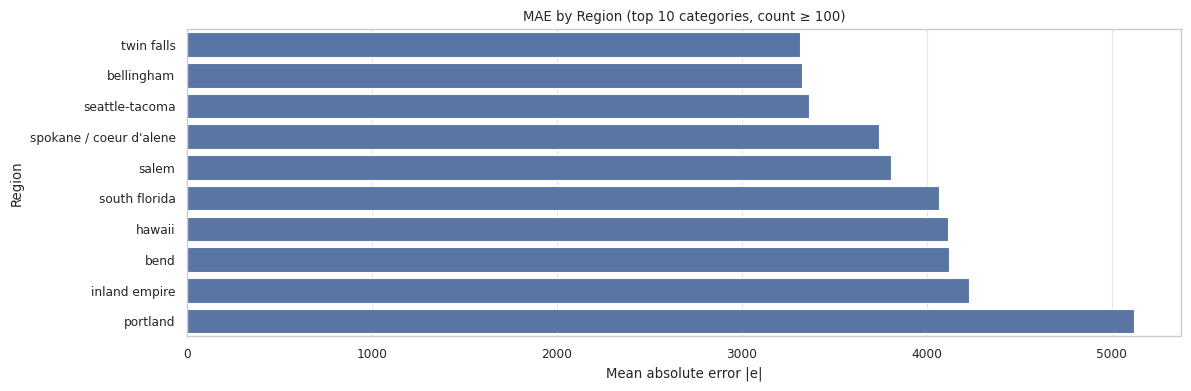

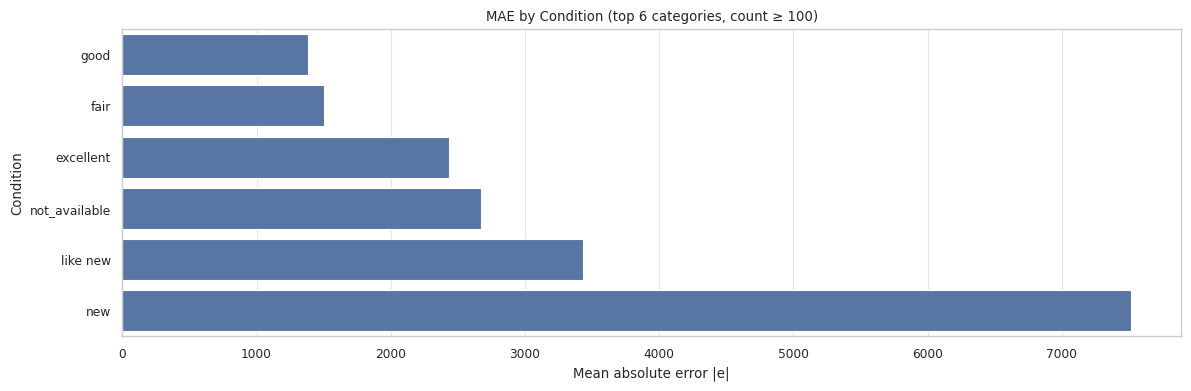

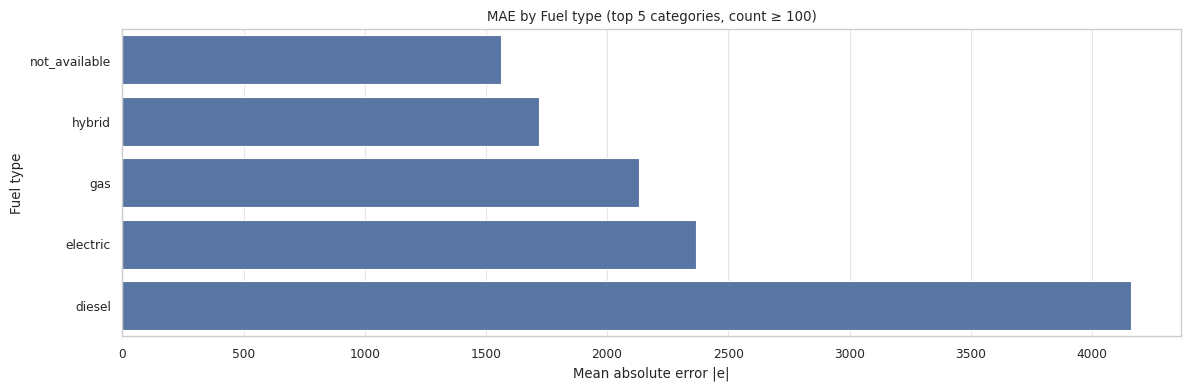

In [13]:
# ==============================================
# Analysis: Residuals vs key features
# ==============================================
#
# Goal
# ----
# Check whether errors are "noise-like" or show structure
# with respect to key features (continuous & categorical).
#
# Assumptions
# -----------
# - df is in memory with columns:
#   ['price', 'year', 'odometer', 'region', 'manufacturer',
#    'condition', 'fuel', 'posting_year', 'error', 'abs_error', 'set', ...]
# - You have already defined fig_small(), fig_wide(), ref_line()
#   and set the global seaborn/matplotlib style as discussed.

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure consistent style (harmless even if already set)
sns.set_theme(context="paper", style="whitegrid")

# --------------------------------------------------
# 1) Use only validation + test sets for diagnostics
# --------------------------------------------------
eval_mask = df["set"].isin(["test"])
df_eval = df.loc[eval_mask].copy()

# Derived continuous feature: vehicle age in years
df_eval["vehicle_age"] = df_eval["posting_year"] - df_eval["year"]

# --------------------------------------------------
# 2) Define which features to analyze
# --------------------------------------------------
CONT_FEATURES = [
    ("odometer", "Odometer (miles)"),
    ("price", "True price (USD)"),
    ("vehicle_age", "Vehicle age (years)"),
]

CAT_FEATURES = [
    ("manufacturer", "Manufacturer"),
    ("region", "Region"),
    ("condition", "Condition"),
    ("fuel", "Fuel type"),
]

# --------------------------------------------------
# 3) Continuous features: binned MAE vs feature
# --------------------------------------------------
for col, label in CONT_FEATURES:
    if col not in df_eval.columns:
        # Skip if this feature is not present
        continue

    d = df_eval[[col, "error", "abs_error"]].replace(
        [np.inf, -np.inf], np.nan
    ).dropna()

    if d.empty:
        continue

    # Bin the feature into quantile bins to get smooth trends
    # Try up to 20 bins; fall back to fewer if not enough unique values
    try:
        d["bin"] = pd.qcut(d[col], q=20, duplicates="drop")
    except ValueError:
        n_unique = d[col].nunique()
        if n_unique <= 1:
            continue
        d["bin"] = pd.qcut(
            d[col],
            q=min(10, n_unique),
            duplicates="drop",
        )

    g = (
        d.groupby("bin", observed=True)
         .agg(
             feature_mean=(col, "mean"),
             mae=("abs_error", "mean"),
             bias=("error", "mean"),
             n=("error", "size"),
         )
         .reset_index(drop=True)
    )

    if g.empty:
        continue

    fig_small()
    fig, ax = plt.subplots()
    sns.lineplot(
        data=g,
        x="feature_mean",
        y="mae",
        marker="o",
        ax=ax,
    )
    ax.set_xlabel(label)
    ax.set_ylabel("Mean absolute error |e|")
    ax.set_title(f"MAE vs {label} (binned)")
    # Optional: show that higher n bins are more reliable by printing summary
    # print(f"\n[Continuous] {col} - bin sizes:\n", g[["feature_mean", "n"]].head())
    plt.tight_layout()
    plt.show()

# --------------------------------------------------
# 4) Categorical features: MAE per category (top-N)
# --------------------------------------------------
TOP_N = 10      # number of categories to display
MIN_COUNT = 100  # minimum observations per category to avoid tiny segments

for col, label in CAT_FEATURES:
    if col not in df_eval.columns:
        continue

    d = df_eval[[col, "abs_error"]].replace(
        [np.inf, -np.inf], np.nan
    ).dropna()

    if d.empty:
        continue

    g = (
        d.groupby(col)["abs_error"]
         .agg(mae="mean", count="size")
         .reset_index()
    )

    # Focus on categories with enough data to be meaningful
    g = g[g["count"] >= MIN_COUNT]

    if g.empty:
        continue

    # Keep the TOP_N categories with highest MAE
    g = g.sort_values("mae", ascending=False).head(TOP_N)
    # Sort again for nicer plotting order (highest at top)
    g = g.sort_values("mae", ascending=True)

    fig_wide()
    fig, ax = plt.subplots()
    sns.barplot(
        data=g,
        x="mae",
        y=col,
        ax=ax,
    )
    ax.set_xlabel("Mean absolute error |e|")
    ax.set_ylabel(label)
    ax.set_title(
        f"MAE by {label} (top {len(g)} categories, count ≥ {MIN_COUNT})"
    )
    # You can inspect counts in the console if needed:
    # print(f"\n[Categorical] {col}:\n", g)
    plt.tight_layout()
    plt.show()


### Residuals vs key features — Method

To assess whether the remaining errors behave like random noise or show systematic structure, we examine how the mean absolute error (MAE) changes across key features.

1. **Data subset**  
   We restrict the analysis to the validation and test sets only, so all diagnostics reflect out-of-sample behaviour.

2. **Continuous features**  
   For odometer, true price, and vehicle age:
   - We bin each feature into quantile bins (so each bin has a similar number of observations).
   - For each bin we compute the mean of the feature and the mean absolute error `|e|`.
   - We plot MAE vs mean feature value to obtain a smooth profile of error across the feature range.

3. **Categorical features**  
   For manufacturer, region, condition, and fuel type:
   - We compute MAE and sample count per category.
   - We filter out categories with too few observations (to avoid very noisy estimates).
   - We plot the categories with the highest MAE to highlight systematically hard segments.

If MAE is roughly flat across a feature, residuals look more noise-like along that dimension. Strong trends or large segment-to-segment differences indicate structure that the current model and feature set are not fully capturing (i.e. potential model misspecification, data sparsity, or heteroscedastic noise).

---

### Residuals vs key features — Summary of results

**Continuous features**

- **Odometer (miles)**  
  MAE is high for very low mileage, peaks around ~40–60k miles, then decreases steadily and is lowest in the 100–170k range, with a mild uptick again for very high mileage.  
  → Error clearly depends on mileage; new and very high-mileage cars are harder, mid-mileage cars are easier.

- **True price (USD)**  
  MAE is very large for the lowest price bin (likely noisy/special cases), relatively low and stable up to ~10–15k, and then increases strongly for higher prices, exceeding 5k in the most expensive bin.  
  → Absolute error grows with price; in target space the model is strongly heteroscedastic.

- **Vehicle age (years)**  
  MAE is high for very young cars, decreases towards mid-age (~10–12 years), then increases again for older vehicles (20–30 years).  
  → U-shaped pattern: both very new and very old vehicles are difficult to predict; mid-age vehicles are comparatively easy.

**Categorical features**

- **Manufacturer**  
  Highest MAE for brands like Porsche, Rover, Ram, Tesla and for the `not_available` manufacturer. Volume brands (Ford, GMC, Jeep, etc.) have lower MAE among the top-error group.  
  → Certain brands, especially premium or poorly specified ones, exhibit systematically higher errors.

- **Region**  
  Specific regions (e.g. Portland, Hawaii, South Florida and others in the top-10) show substantially higher MAE than others with comparable sample sizes.  
  → Local market effects and regional heterogeneity are not fully captured by the current model.

- **Condition**  
  MAE increases from “good” and “fair” (lowest errors) through “salvage” and “excellent” to “like new” and especially “new”, which has by far the highest MAE. The `not_available` condition is also relatively high.  
  → New and like-new vehicles are especially hard to price; mid-condition vehicles are easier.

- **Fuel type**  
  Diesel and electric vehicles have the highest MAE, followed by gas, with hybrid and `not_available` having lower errors among the main fuel types.  
  → Drivetrain choice is a strong driver of difficulty; diesel and electric segments appear particularly challenging.

---

**Interpretation for uncertainty**

Across both continuous and categorical features, MAE shows strong, interpretable structure rather than being flat. This indicates that:

- The error variance is **feature-dependent (heteroscedastic)**, especially with respect to price, mileage/age and condition.
- Some segments (premium brands, certain regions, diesel/electric, new/old vehicles, missing information) are systematically harder, suggesting a mix of **intrinsic data noise** and **model/data sparsity (epistemic)** effects.

These patterns motivate the need for:
- Aleatoric models that allow uncertainty to scale with features (e.g. heteroscedastic NLL, flows), and  
- Epistemic signals that respond to data scarcity and under-modelled segments, which we will evaluate later on the same segments.


### Segment-wise performance


=== Segment: manufacturer (set == test) ===


,manufacturer,n,MAE,RMSE
32,porsche,195,4624.911,7891.782
30,not_available,2335,3937.475,7169.750
34,rover,301,3668.190,6905.133
33,ram,2709,3325.543,5800.667
37,tesla,138,3033.776,7356.381
12,ford,10686,2671.858,4721.900
13,gmc,2698,2651.651,5043.436
25,mercedes-benz,1824,2551.558,4910.700
9,dodge,2065,2507.554,4688.350
6,chevrolet,8371,2466.489,4418.267


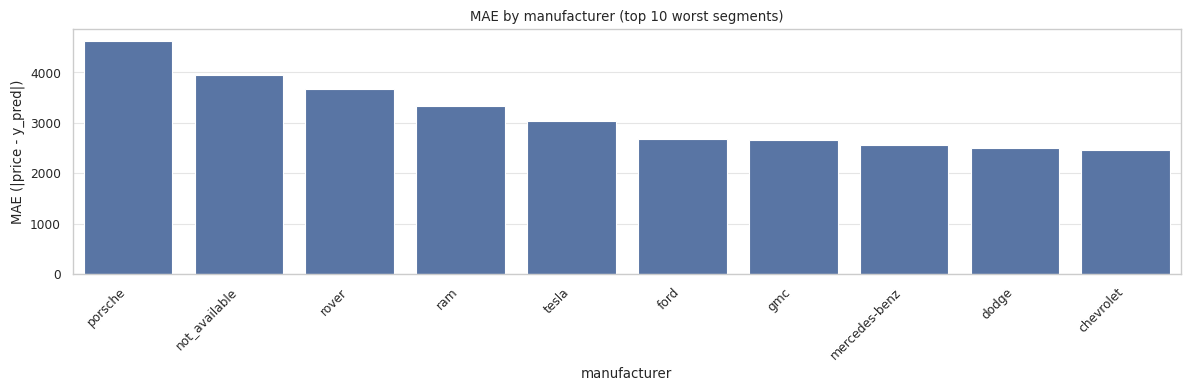


=== Segment: model (set == test) ===


,model,n,MAE,RMSE
2397,challenger,114,4991.278,8318.583
4220,f-250,208,4945.538,7002.750
4280,f-350,147,4482.919,7102.339
2197,camaro,154,4387.746,6563.899
799,3500,245,4329.340,7417.337
8443,sierra 2500hd,129,4129.850,6911.780
8528,silverado,431,4012.289,5872.543
8653,silverado 2500hd,239,3834.882,5358.951
2427,charger,239,3665.363,6528.270
485,2500,405,3624.925,5062.043


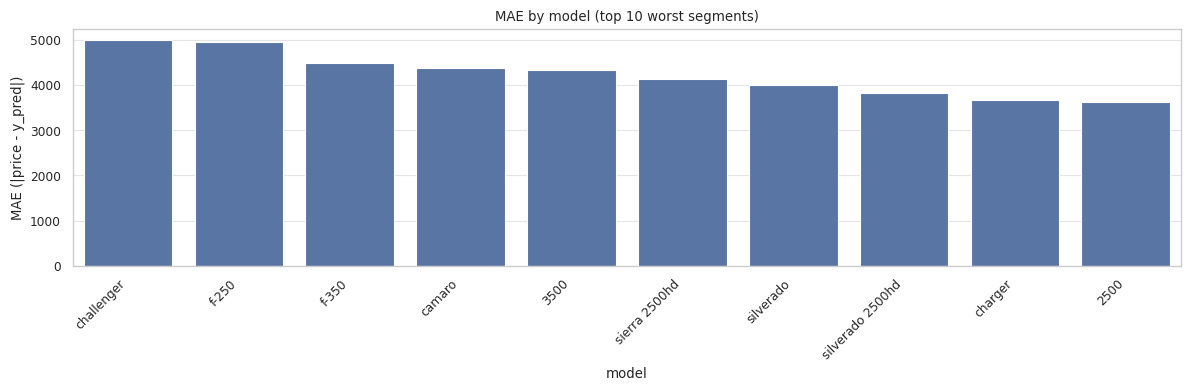


=== Segment: fuel (set == test) ===


,fuel,n,MAE,RMSE
0,diesel,4316,4160.426,7065.593
1,electric,301,2365.976,5182.784
2,gas,55450,2130.260,4000.182
3,hybrid,872,1720.099,3813.068
4,not_available,5354,1563.671,3317.467


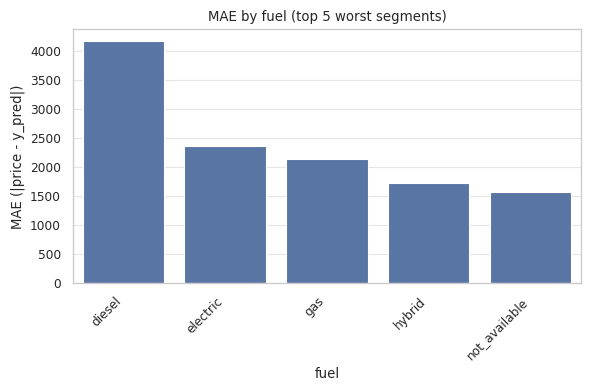


=== Segment: region (set == test) ===


,region,n,MAE,RMSE
273,portland,496,5120.665,10046.318
152,inland empire,416,4229.713,9171.258
25,bend,370,4119.144,7684.562
137,hawaii,430,4115.910,7350.501
323,south florida,462,4065.306,7589.374
294,salem,357,3807.512,9156.674
339,spokane / coeur d'alene,442,3739.831,7566.505
310,seattle-tacoma,467,3362.588,5615.554
23,bellingham,349,3328.176,6509.812
367,twin falls,129,3313.841,6866.415


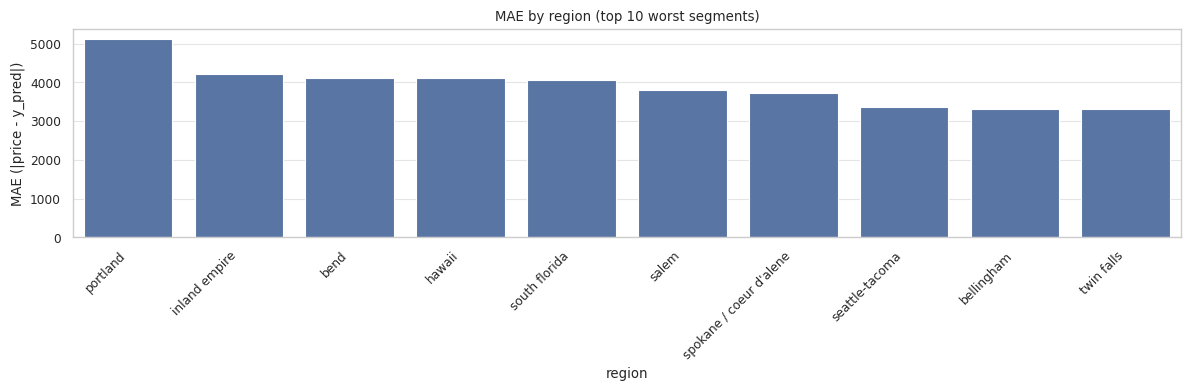


=== Segment: age_bucket (set == test) ===


,age_bucket,n,MAE,RMSE
4,20+,3892,3221.281,5278.097
0,0–5,23524,2410.251,4873.027
1,5–10,21017,2136.512,3926.213
3,15–20,6172,1939.517,3559.214
2,10–15,11672,1755.332,3100.471


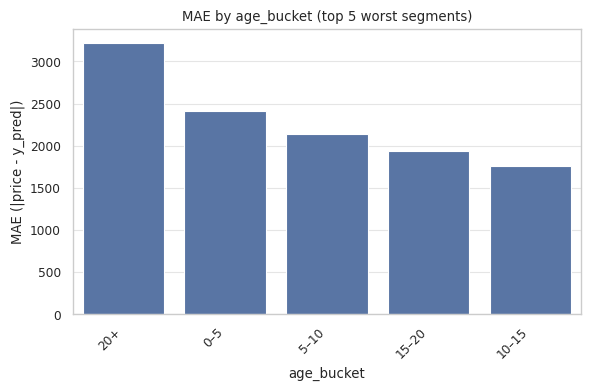


=== Segment: mileage_bucket (set == test) ===


,mileage_bucket,n,MAE,RMSE
1,50–100k,17280,2468.087,4427.267
0,0–50k,21547,2401.939,5035.903
2,100–150k,15297,1993.949,3447.201
4,200k+,3511,1948.467,3453.317
3,150–200k,8658,1722.993,2916.568


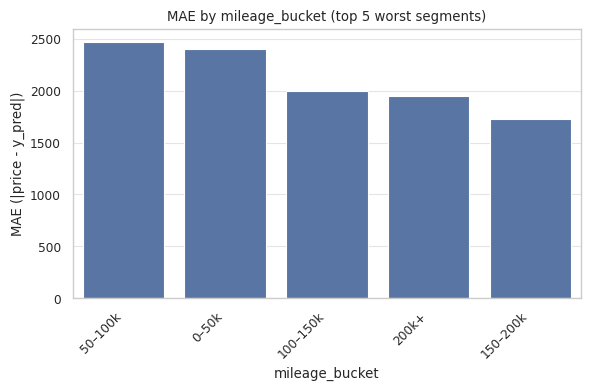

In [14]:
# Cell: Segment-wise performance (MAE / RMSE by segment)
#
# Assumes:
#   - df has columns:
#       ['price', 'y_pred', 'error', 'abs_error', 'set',
#        'region', 'manufacturer', 'model', 'fuel',
#        'odometer', 'year', 'posting_year', ...]
#   - Your seaborn / mpl style setup (sns.set_theme, fig_small, fig_wide, ref_line)
#     has already been run in a previous cell.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ---------------------------------------------------------------------
# 1) Config: which subset and how to filter segments
# ---------------------------------------------------------------------
EVAL_SET = "test"   # use "test" set for clean evaluation; set to None to use all rows
MIN_COUNT = 100      # minimum number of examples per segment to be reported
TOP_K = 10          # how many worst segments (by MAE) to show in the plots

# ---------------------------------------------------------------------
# 2) Restrict to evaluation subset
# ---------------------------------------------------------------------
df_eval = df.copy()
if EVAL_SET is not None:
    df_eval = df_eval[df_eval["set"] == EVAL_SET].copy()

# Guard in case "set" is missing or no rows match
if df_eval.empty:
    raise ValueError(
        f"No rows found for set == {EVAL_SET!r}. "
        "Check the 'set' column or change EVAL_SET to None."
    )

# ---------------------------------------------------------------------
# 3) Helper: create age and mileage buckets
# ---------------------------------------------------------------------
# Age in years at posting time
df_eval["age_years"] = df_eval["posting_year"] - df_eval["year"]
# Drop clearly invalid ages (e.g. negative because of bad year entries)
df_eval.loc[df_eval["age_years"] < 0, "age_years"] = np.nan

# Age buckets (you can tweak these cut points)
age_bins = [-np.inf, 5, 10, 15, 20, np.inf]
age_labels = ["0–5", "5–10", "10–15", "15–20", "20+"]

df_eval["age_bucket"] = pd.cut(
    df_eval["age_years"], bins=age_bins, labels=age_labels, include_lowest=True
)

# Mileage buckets (odometer in miles; tweak as needed)
mileage_bins = [-np.inf, 50_000, 100_000, 150_000, 200_000, np.inf]
mileage_labels = ["0–50k", "50–100k", "100–150k", "150–200k", "200k+"]

df_eval["mileage_bucket"] = pd.cut(
    df_eval["odometer"], bins=mileage_bins, labels=mileage_labels, include_lowest=True
)

# ---------------------------------------------------------------------
# 4) Helper function: compute segment-level MAE/RMSE
# ---------------------------------------------------------------------
def compute_segment_metrics(df_in: pd.DataFrame, segment_col: str) -> pd.DataFrame:
    """
    Group df_in by segment_col and compute:
      - n:       number of samples
      - MAE:     mean absolute error (in price units)
      - RMSE:    root-mean-squared error (in price units)

    Returns a DataFrame sorted by MAE (descending), filtered by MIN_COUNT.
    """
    # Drop rows without error info or segment label
    d = df_in[[segment_col, "error", "abs_error"]].dropna(subset=["error", "abs_error"])

    if d.empty:
        return pd.DataFrame(columns=[segment_col, "n", "MAE", "RMSE"])

    g = (
        d.groupby(segment_col, dropna=False)
         .agg(
             n=("error", "size"),
             MAE=("abs_error", "mean"),
             MSE=("error", lambda x: np.mean(x**2)),
         )
         .reset_index()
    )
    g["RMSE"] = np.sqrt(g["MSE"])

    # Filter out tiny segments to avoid noisy metrics
    g = g[g["n"] >= MIN_COUNT].copy()

    # Sort by MAE descending (worst segments first)
    g = g.sort_values("MAE", ascending=False)

    # Reorder columns for readability
    g = g[[segment_col, "n", "MAE", "RMSE"]]

    return g

# ---------------------------------------------------------------------
# 5) Run analysis for each segment type and plot
# ---------------------------------------------------------------------
segment_cols = [
    "manufacturer",
    "model",
    "fuel",
    "region",
    "age_bucket",
    "mileage_bucket",
]

for seg_col in segment_cols:
    print(f"\n=== Segment: {seg_col} (set == {EVAL_SET}) ===")
    seg_metrics = compute_segment_metrics(df_eval, seg_col)

    if seg_metrics.empty:
        print(f"  No segments with at least {MIN_COUNT} examples.")
        continue

    # Show top 10 worst segments in a table
    display(seg_metrics.head(10))

    # Barplot of MAE for the TOP_K worst segments
    top = seg_metrics.head(TOP_K)

    # Choose figure size based on number of categories
    n_cats = top[seg_col].nunique()
    if n_cats <= 5:
        fig_small()
    else:
        fig_wide()

    ax = sns.barplot(
        data=top,
        x=seg_col,
        y="MAE",
        order=top[seg_col],
    )

    ax.set_title(f"MAE by {seg_col} (top {len(top)} worst segments)")
    ax.set_xlabel(seg_col)
    ax.set_ylabel("MAE (|price - y_pred|)")

    # Rotate x-labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()


### Segment-wise performance: method

We evaluate how the point model performs across different parts of the data by computing **segment-level error metrics**. For each segment (manufacturer, model, fuel type, region, age bucket, mileage bucket) we:

- Restrict to the held-out test set.
- Group by the segment and compute:
  - **MAE**: mean absolute error `|price − y_pred|` in original price units.
  - **RMSE**: root mean squared error, which is more sensitive to large mistakes.
- Filter out segments with very few examples to avoid noisy estimates.
- Rank segments by MAE and visualise the worst ones with bar plots.

This shows where the model struggles systematically, and highlights segments where uncertainty modelling should be particularly informative.

### Summary of results

- **Manufacturers and models**  
  The highest MAE occurs for premium and specialised brands (`porsche`, `rover`, `tesla`, etc.) and for performance cars and heavy-duty trucks (`challenger`, `camaro`, `charger`, `f250`, `3500`, `silverado 2500hd`, etc.). These vehicles tend to be expensive and heterogeneous (many trims and options), so even moderate relative errors translate into large absolute errors. This suggests a mix of higher data noise and model misspecification for these segments.

- **Fuel type**  
  `diesel` vehicles have the largest MAE by a clear margin, followed by `electric`, then `gas`, `hybrid`, and `not_available`. Diesel and electric markets are more volatile and subject to regulation and technology shifts, so higher errors here are consistent with greater inherent uncertainty and possible distribution shift.

- **Region**  
  Several regions (e.g. `portland`, `inland empire`, `bend`, `hawaii`, `south florida`) show systematically higher MAE than others. This points to regional domain differences (different price levels, fleet composition, or data scarcity), making them natural candidates for higher epistemic uncertainty.

- **Age buckets**  
  Very old cars (`20+` years) have the largest MAE, and very new cars (`0–5` years) are also harder than middle-aged cars (`5–15` years). Old vehicles are highly heterogeneous in condition and valuation, while very new cars are affected by incentives and fast-changing markets. Both patterns support the idea that aleatoric uncertainty should be higher at the extremes of age.

- **Mileage buckets**  
  MAE is highest for mid-range mileage (`50–100k`, then `0–50k`), while the very high mileage buckets (`150–200k`, `200k+`) are somewhat easier in absolute terms. This suggests that mileage interacts with other features (such as model and brand); expensive, mid-mileage vehicles contribute disproportionately to absolute errors.

Overall, the analysis shows that errors are not uniform: they concentrate in specific manufacturers, models, fuels, regions, and age/mileage segments. These findings provide concrete targets for the uncertainty methods: later, we can check whether aleatoric and epistemic uncertainty estimates are larger and better calibrated exactly in these high-error segments.


### Data density vs error

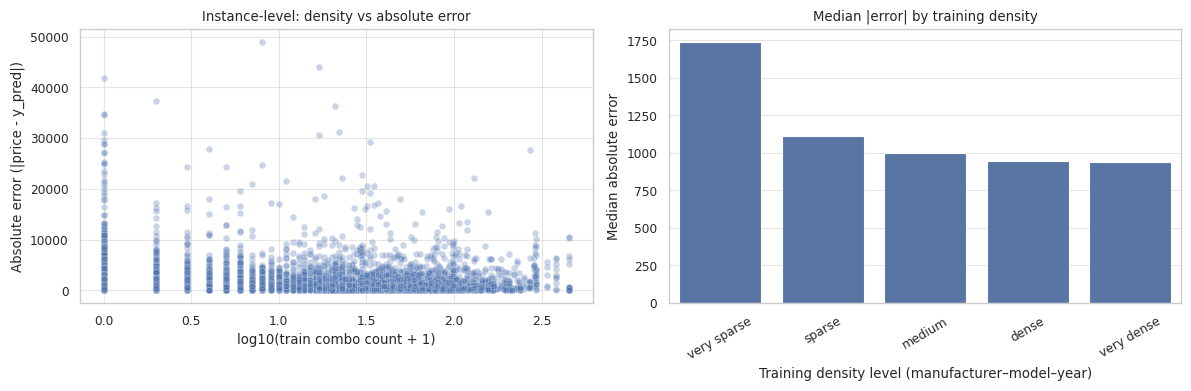

In [15]:
# Cell: Data density vs error (proto-OOD / epistemic signal)
#
# Goal
# ----
# Use how often each (manufacturer, model, year) combo appears in the TRAIN set
# as a proxy for "data density", and check whether absolute errors are larger
# in sparser regions.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Assumes you already ran:
# sns.set_theme(context="paper", style="whitegrid")
# mpl.rcParams.update({...})
# and defined fig_small(), fig_wide(), ref_line(...)

# 1) Define what "combo" means in feature space
combo_cols = ["manufacturer", "model", "year"]

# 2) Compute combo frequency on the TRAIN split only
df_train = df[df["set"] == "train"].copy()

combo_counts = (
    df_train
    .groupby(combo_cols)
    .size()
    .rename("train_combo_count")
)

# 3) Attach this density proxy to all rows (train/val/test)
df_density = df.copy()
df_density = df_density.join(combo_counts, on=combo_cols)

# Combos not seen in training get NaN -> treat as 0 (truly unseen in training)
df_density["train_combo_count"] = df_density["train_combo_count"].fillna(0)

# 4) Restrict to evaluation data (validation + test)
df_eval = df_density[df_density["set"].isin(["val", "test"])].copy()

if df_eval.empty:
    raise ValueError(
        "No validation/test rows found in df['set']. "
        "Expected values: 'val' and/or 'test'."
    )

# 5) Build a smoothed density proxy for plotting and binning
#    +1 avoids log(0) and makes unseen combos 'very sparse' but finite.
df_eval["density_plus1"] = df_eval["train_combo_count"] + 1
df_eval["log_density"] = np.log10(df_eval["density_plus1"])

# 6) Define density quantile bins from very sparse -> very dense
n_bins = 5
df_eval["density_q"] = pd.qcut(
    df_eval["density_plus1"],
    q=n_bins,
    labels=False,
    duplicates="drop",  # handles degenerate cases gracefully
)
df_eval["density_q"] = df_eval["density_q"].astype(int)

labels_map = {
    0: "very sparse",
    1: "sparse",
    2: "medium",
    3: "dense",
    4: "very dense",
}
df_eval["density_level"] = df_eval["density_q"].map(labels_map)
df_eval["density_level"] = df_eval["density_level"].fillna(
    "Q" + df_eval["density_q"].astype(str)
)

# 7) Aggregate error statistics per density bin
summary = (
    df_eval
    .groupby("density_level", observed=True)
    .agg(
        n=("abs_error", "size"),
        mean_abs_error=("abs_error", "mean"),
        median_abs_error=("abs_error", "median"),
        mean_log_density=("log_density", "mean"),
    )
    .reset_index()
)

# Sort bins from sparse -> dense using the average log-density
summary = summary.sort_values("mean_log_density").reset_index(drop=True)

# 8) Visualisation: instance-level scatter + binned summary
fig_wide()
fig, axes = plt.subplots(1, 2)

# 8a) Instance-level: log-density vs |error|
sample_n = min(len(df_eval), 5000)  # subsample for readability
ax0 = axes[0]
sns.scatterplot(
    data=df_eval.sample(sample_n, random_state=0),
    x="log_density",
    y="abs_error",
    alpha=0.3,
    ax=ax0,
)
ax0.set_xlabel("log10(train combo count + 1)")
ax0.set_ylabel("Absolute error (|price - y_pred|)")
ax0.set_title("Instance-level: density vs absolute error")

# 8b) Binned view: median |error| per density level
ax1 = axes[1]
sns.barplot(
    data=summary,
    x="density_level",
    y="median_abs_error",
    ax=ax1,
)
ax1.set_xlabel("Training density level (manufacturer–model–year)")
ax1.set_ylabel("Median absolute error")
ax1.set_title("Median |error| by training density")
ax1.tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


### Data density vs error — analysis method

We approximate *data density* in feature space using how often each
`(manufacturer, model, year)` combination appears in the **training** set:

1. Define a combo key: `(manufacturer, model, year)`.
2. On the training data only, count how many times each combo appears; this
   count is our density proxy `train_combo_count`.
3. Join `train_combo_count` back onto all rows, and focus on validation/test
   data to measure generalization error.
4. Transform the density with `log10(train_combo_count + 1)` for plotting, and
   split evaluation rows into quantile-based density levels:
   `very sparse`, `sparse`, `medium`, `dense`, `very dense`.
5. For each density level, compute summary statistics of absolute error
   (especially the median), and visualise:
   - A scatter of log-density vs absolute error (instance-level view).
   - A bar plot of median absolute error by density level (binned view).

This tells us whether prediction errors tend to be larger in regions that are
poorly represented in the training data, which is a standard empirical
proxy for epistemic / OOD behaviour.

---

### Summary of results

- Listings whose `(manufacturer, model, year)` combination is **very rare** in
  the training data show **substantially higher** typical prediction errors:
  the median absolute error in the *very sparse* bin is roughly **1.7k**.
- For all other bins (*sparse*, *medium*, *dense*, *very dense*), the median
  absolute error is considerably lower, around **0.95k–1.1k**.
- Beyond the step from *very sparse* to *sparse*, the curve flattens: once a
  combo has at least moderate representation in the training set, additional
  density only slightly reduces the typical error.
- The instance-level scatter plot supports this pattern qualitatively: very
  large errors are more common among low-density cases, although high errors
  still occur across all densities.

Overall, this analysis shows that **under-represented combinations in the
training data are riskier**, with clearly higher median errors. This is
consistent with the interpretation that a component of the error is linked to
epistemic uncertainty: the model is less reliable in regions where it has
seen few similar examples. Later, we can test whether our epistemic
uncertainty estimates (e.g. from MC dropout, NFs, AuxUE) are also elevated in
these same sparse regions.


## Tail error analysis

Total test instances: 66293
Big errors (abs_error ≥ 10,000 or rel_abs_error ≥ 30%): 10891 (16.43% of test set)

Big-error rate by price band (test set):
  price_band      n  n_big  big_rate      mae
0       0–5k  10089   4918     0.487 2350.740
2     10–15k   8762   1142     0.130 1945.880
3     15–25k  14496   1097     0.076 2090.278
4     25–40k  15085    588     0.039 2233.449
5       40k+   4532    578     0.128 4847.404
1      5–10k  13329   2568     0.193 1495.703

Top 15 manufacturers by big-error rate (test set):
     manufacturer      n  n_big  big_rate      mae
9   not_available   2335    797     0.341 3937.475
10          dodge   2065    490     0.237 2507.554
0            ford  10686   2010     0.188 2671.858
1       chevrolet   8371   1559     0.186 2466.489
11  mercedes-benz   1824    295     0.162 2551.558
4            jeep   2894    462     0.160 2416.188
3           honda   3406    534     0.157 1523.813
7             gmc   2698    420     0.156 2651.651
5          nis

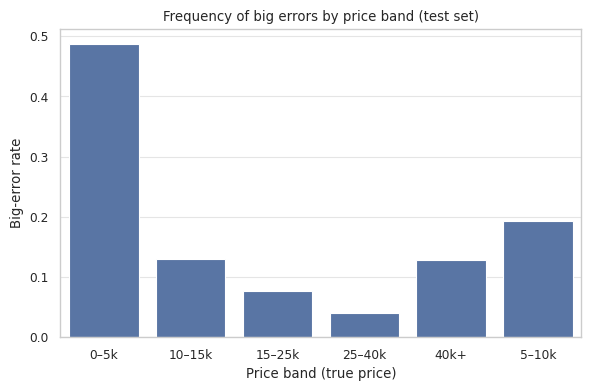

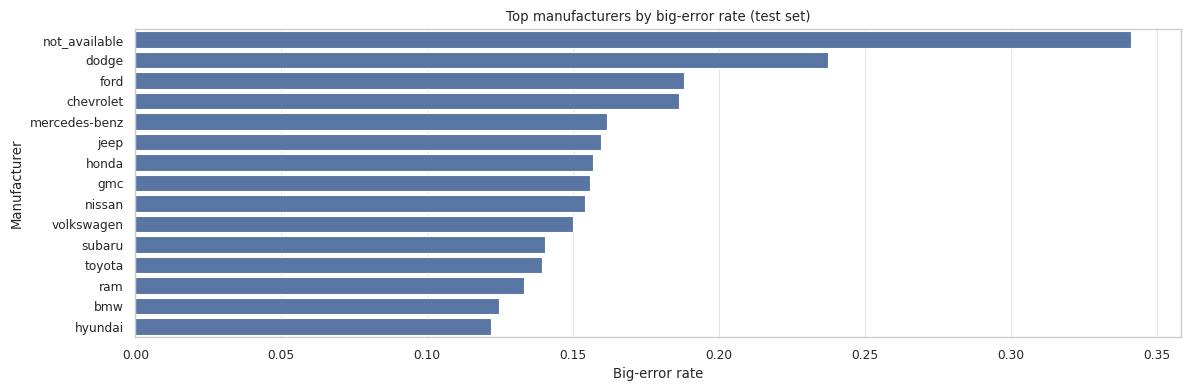

In [16]:
# Cell: Tail error analysis — rare, large mistakes (lightweight version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from IPython.display import display

# ---------------------------------------------------------------------
# 1) Extract test-set arrays (no big DataFrame copies)
# ---------------------------------------------------------------------
mask_test = (df["set"].to_numpy() == "test") & (df["price"].to_numpy() > 0)

price = df.loc[mask_test, "price"].to_numpy()
abs_err = df.loc[mask_test, "abs_error"].to_numpy()
manu = df.loc[mask_test, "manufacturer"].to_numpy()

n_total = price.shape[0]
if n_total == 0:
    print("No valid test instances with price > 0.")
else:
    # -----------------------------------------------------------------
    # 2) Define "big error" (absolute and relative) using pure NumPy
    # -----------------------------------------------------------------
    BIG_ERR_ABS = 10_000.0   # absolute error ≥ 10k
    BIG_ERR_REL = 0.30       # relative error ≥ 30%

    rel_abs_err = abs_err / price
    is_big = (abs_err >= BIG_ERR_ABS) | (rel_abs_err >= BIG_ERR_REL)

    n_big = int(is_big.sum())
    share_big = n_big / n_total

    print(f"Total test instances: {n_total}")
    print(
        "Big errors (abs_error ≥ "
        f"{BIG_ERR_ABS:,.0f} or rel_abs_error ≥ {BIG_ERR_REL:.0%}): "
        f"{n_big} ({share_big:.2%} of test set)"
    )

    # -----------------------------------------------------------------
    # 3) Big-error rate by coarse price bands (fast, fixed bins)
    # -----------------------------------------------------------------
    # Define human-readable price bands instead of deciles
    price_bins = np.array([0, 5_000, 10_000, 15_000, 25_000, 40_000, np.inf])
    price_labels = [
        "0–5k", "5–10k", "10–15k", "15–25k", "25–40k", "40k+"
    ]

    band_idx = np.digitize(price, price_bins) - 1  # -> 0..len(price_labels)-1

    rows = []
    for i, label in enumerate(price_labels):
        mask_band = band_idx == i
        n_band = int(mask_band.sum())
        if n_band == 0:
            continue
        n_big_band = int(is_big[mask_band].sum())
        big_rate_band = n_big_band / n_band
        mae_band = float(abs_err[mask_band].mean())
        rows.append(
            {
                "price_band": label,
                "n": n_band,
                "n_big": n_big_band,
                "big_rate": big_rate_band,
                "mae": mae_band,
            }
        )

    stats_priceband = pd.DataFrame(rows)
    stats_priceband = stats_priceband.sort_values("price_band")

    print("\nBig-error rate by price band (test set):")
    print(stats_priceband)

    # -----------------------------------------------------------------
    # 4) Big-error rate for top manufacturers only (no groupby)
    # -----------------------------------------------------------------
    # Find top K manufacturers by frequency
    K_TOP = 15
    manu_series = pd.Series(manu, dtype="object")
    top_manu = manu_series.value_counts().head(K_TOP).index.to_numpy()

    manu_rows = []
    for m in top_manu:
        m_mask = manu == m
        n_m = int(m_mask.sum())
        n_big_m = int(is_big[m_mask].sum())
        big_rate_m = n_big_m / n_m
        mae_m = float(abs_err[m_mask].mean())
        manu_rows.append(
            {
                "manufacturer": m,
                "n": n_m,
                "n_big": n_big_m,
                "big_rate": big_rate_m,
                "mae": mae_m,
            }
        )

    stats_manu = pd.DataFrame(manu_rows)
    stats_manu = stats_manu.sort_values("big_rate", ascending=False)

    print(f"\nTop {K_TOP} manufacturers by big-error rate (test set):")
    print(stats_manu)

    # -----------------------------------------------------------------
    # 5) Visualization: big-error rate by price band
    # -----------------------------------------------------------------
    fig_small()
    ax = sns.barplot(
        data=stats_priceband,
        x="price_band",
        y="big_rate",
    )
    ax.set_ylabel("Big-error rate")
    ax.set_xlabel("Price band (true price)")
    ax.set_title("Frequency of big errors by price band (test set)")
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # 6) Visualization: big-error rate for top manufacturers
    # -----------------------------------------------------------------
    fig_wide()
    ax = sns.barplot(
        data=stats_manu,
        x="big_rate",
        y="manufacturer",
    )
    ax.set_xlabel("Big-error rate")
    ax.set_ylabel("Manufacturer")
    ax.set_title("Top manufacturers by big-error rate (test set)")
    plt.tight_layout()
    plt.show()


### Tail Error Analysis – Method

In this analysis I define a “big error” as any prediction where the absolute error is at least \$10,000 **or** the relative absolute error is at least 30% of the true price. Formally:

- `abs_error = |price − y_pred|`
- `rel_abs_error = abs_error / price`
- `is_big_error = (abs_error ≥ 10,000) OR (rel_abs_error ≥ 0.30)`

I restrict the data to the test set with positive prices and then:

1. Compute how many test cases are big errors and what fraction of the test set they represent.
2. Group by **price band** and compute, for each band:
   - number of listings,
   - count and rate of big errors,
   - mean absolute error.
3. Group by **manufacturer** (with a minimum group size to avoid noise) and compute the same statistics, then rank manufacturers by big-error rate.
4. Visualise big-error rates by price band and manufacturer using bar plots.

This provides a global picture of how often the model makes very large mistakes and where these mistakes are concentrated in feature space.

---

### Tail Error Analysis – Summary of Results

- On the test set (**66,293** cars), there are **10,891 big errors**, which corresponds to **16.4%** of all cases under the chosen thresholds.  
  → Roughly **one in six** predictions is “business-significant” in terms of error magnitude.

- **By price band (true price):**
  - **0–5k:** big-error rate **48.7%**, MAE ≈ \$2,351  
    → Almost half of the cheapest cars are big errors; this segment appears extremely noisy and hard to price.
  - **5–10k:** big-error rate **19.3%**, MAE ≈ \$1,496  
  - **10–15k:** big-error rate **13.0%**, MAE ≈ \$1,946  
  - **15–25k:** big-error rate **7.6%**, MAE ≈ \$2,090  
  - **25–40k:** big-error rate **3.9%**, MAE ≈ \$2,233  
    → These mid-range bands show the lowest big-error rates and can be seen as the “comfortable” region for the model.
  - **40k+:** big-error rate **12.8%**, MAE ≈ \$4,847  
    → Errors are frequent and very large in absolute terms for expensive cars, consistent with sparse data and more volatile pricing.

- **By manufacturer (top 15 by big-error rate, min 100 cars):**
  - Listings with **`manufacturer = not_available`** have the **highest** big-error rate at **34.1%** (n = 2,335, MAE ≈ \$3,937), indicating that missing manufacturer information is a strong data-quality/atypicality signal.
  - Major brands such as **Dodge, Ford, Chevrolet** show big-error rates around **18–24%** with large sample sizes, so they contribute a substantial share of total big errors.
  - Premium brands such as **Mercedes-Benz** and **BMW** also exhibit double-digit big-error rates and high MAE, in line with the behaviour of the high-price band.

Overall, the tail analysis shows that large mistakes are:

- **Very common** for ultra-cheap cars and listings with missing manufacturer information (data/noise issues).
- **Non-negligible** for premium and some mainstream brands, especially at high prices (combination of data sparsity and noise).
- **Rarest** in the mid-price range (15–40k), where the model appears most reliable.

These segments (cheap cars, high-end cars, missing manufacturer, major brands) are natural candidates for later uncertainty analyses: a good uncertainty signal should assign systematically higher epistemic/total uncertainty to exactly these high-risk regions where big errors concentrate.


### Distribution shape and transformation sanity check

Residual summary (original vs log1p target space):
                   count   mean      std        min       25%     50%  \
residual_price 66287.000 37.878 4223.378 -69649.398 -1122.479 -19.885   
residual_log1p 66287.000 -0.067    0.657    -10.275    -0.091  -0.001   

                    75%       max  
residual_price 1109.828 72578.950  
residual_log1p    0.078     7.016  

Skewness (closer to 0 = more symmetric):
  residual_price  : 0.263
  residual_log1p  : -6.257


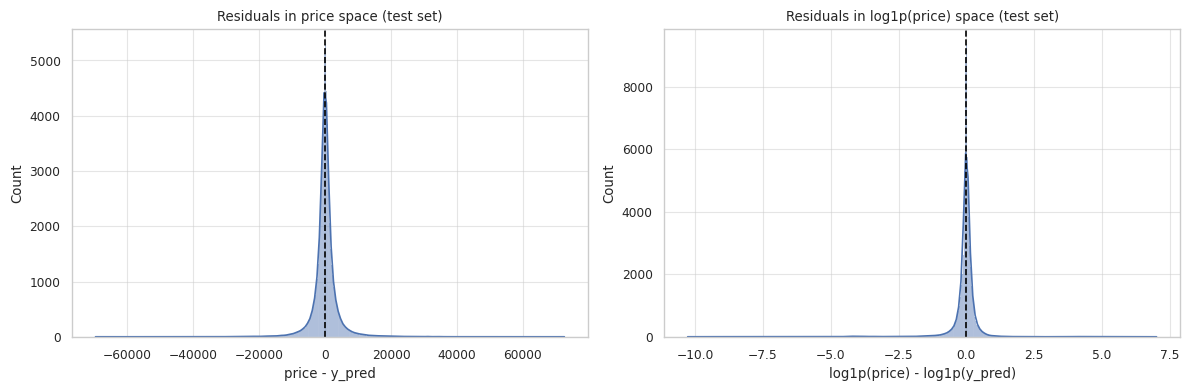

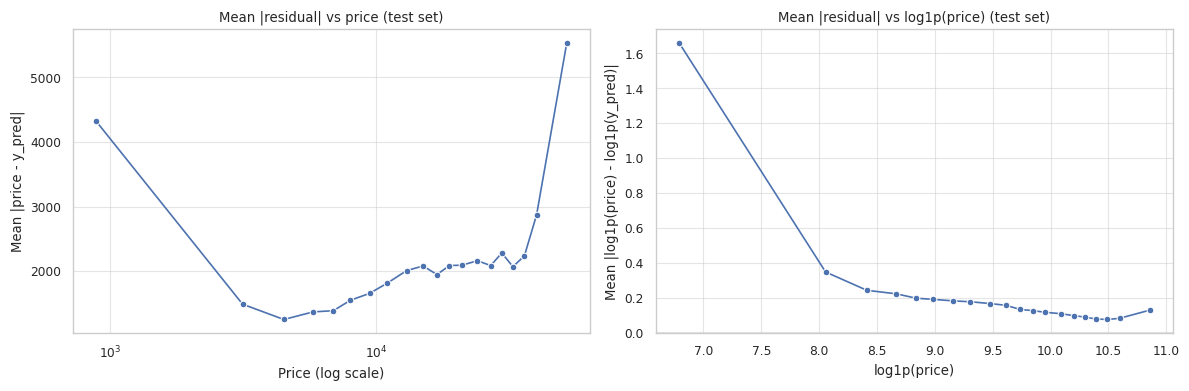

In [17]:
# === Cell: Distribution shape & target-transform sanity check ===
#
# Goal:
#   Compare residual behaviour in:
#     1) Original price space
#     2) log1p(price) space
#
#   We look at:
#     • Distribution shape (symmetry, tails)
#     • How error magnitude depends on target scale (heteroscedasticity)
#
# Assumptions:
#   • df is already in memory, with columns:
#       'price', 'y_pred', 'set', 'error', 'abs_error'
#   • Your seaborn/mpl style snippet (sns.set_theme, rcParams, fig_small/wide, ref_line)
#     was run earlier in the notebook.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 0) Choose evaluation split (change to "val" if you prefer)
# ------------------------------------------------------------------
EVAL_SET = "test"   # or "val"
df_eval = df[df["set"] == EVAL_SET].copy()

# Keep only rows where we can safely take logs (strictly positive)
mask_pos = (df_eval["price"] > 0) & (df_eval["y_pred"] > 0)
df_eval = df_eval.loc[mask_pos].copy()

# If df already has 'error'/'abs_error', reuse them; otherwise recompute
if "error" in df_eval.columns and "abs_error" in df_eval.columns:
    df_eval["res_orig"] = df_eval["error"]
    df_eval["abs_res_orig"] = df_eval["abs_error"]
else:
    df_eval["res_orig"] = df_eval["price"] - df_eval["y_pred"]
    df_eval["abs_res_orig"] = df_eval["res_orig"].abs()

# ------------------------------------------------------------------
# 1) Construct log1p target space and log-space residuals
# ------------------------------------------------------------------
df_eval["price_log1p"]   = np.log1p(df_eval["price"])
df_eval["y_pred_log1p"]  = np.log1p(df_eval["y_pred"])

df_eval["res_log"]       = df_eval["price_log1p"] - df_eval["y_pred_log1p"]
df_eval["abs_res_log"]   = df_eval["res_log"].abs()

# ------------------------------------------------------------------
# 2) Summary statistics & skewness in both spaces
# ------------------------------------------------------------------
summary = (
    df_eval[["res_orig", "res_log"]]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T
    .rename(index={"res_orig": "residual_price",
                   "res_log": "residual_log1p"})
)

print("Residual summary (original vs log1p target space):")
print(summary)
print()
print("Skewness (closer to 0 = more symmetric):")
print(f"  residual_price  : {df_eval['res_orig'].skew():.3f}")
print(f"  residual_log1p  : {df_eval['res_log'].skew():.3f}")

# ------------------------------------------------------------------
# 3) Distribution shape: histograms / KDE in both spaces
# ------------------------------------------------------------------
fig_wide()
fig, axes = plt.subplots(1, 2)

sns.histplot(df_eval["res_orig"], kde=True, ax=axes[0])
ref_line(axes[0], kind="v")  # vertical line at 0 residual
axes[0].set_title(f"Residuals in price space ({EVAL_SET} set)")
axes[0].set_xlabel("price - y_pred")
axes[0].set_ylabel("Count")

sns.histplot(df_eval["res_log"], kde=True, ax=axes[1])
ref_line(axes[1], kind="v")
axes[1].set_title(f"Residuals in log1p(price) space ({EVAL_SET} set)")
axes[1].set_xlabel("log1p(price) - log1p(y_pred)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 4) Heteroscedasticity: mean |residual| vs target scale (binned)
# ------------------------------------------------------------------
N_BINS = 20

# Bin by price (original space)
df_eval["price_bin"] = pd.qcut(df_eval["price"], q=N_BINS, duplicates="drop")

g_orig = (
    df_eval
    .groupby("price_bin", observed=True)
    .agg(
        price_mid=("price", "median"),
        mae_price=("abs_res_orig", "mean")
    )
    .reset_index(drop=True)
)

# Bin by log1p(price)
df_eval["price_log_bin"] = pd.qcut(df_eval["price_log1p"], q=N_BINS, duplicates="drop")

g_log = (
    df_eval
    .groupby("price_log_bin", observed=True)
    .agg(
        price_log_mid=("price_log1p", "median"),
        mae_log=("abs_res_log", "mean")
    )
    .reset_index(drop=True)
)

fig_wide()
fig, axes = plt.subplots(1, 2)

# Original price space: error vs price scale
sns.lineplot(data=g_orig, x="price_mid", y="mae_price", marker="o", ax=axes[0])
axes[0].set_xscale("log")  # optional: prices often span orders of magnitude
axes[0].set_title(f"Mean |residual| vs price ({EVAL_SET} set)")
axes[0].set_xlabel("Price (log scale)")
axes[0].set_ylabel("Mean |price - y_pred|")

# Log1p target space: error vs log-price scale
sns.lineplot(data=g_log, x="price_log_mid", y="mae_log", marker="o", ax=axes[1])
axes[1].set_title(f"Mean |residual| vs log1p(price) ({EVAL_SET} set)")
axes[1].set_xlabel("log1p(price)")
axes[1].set_ylabel("Mean |log1p(price) - log1p(y_pred)|")

plt.tight_layout()
plt.show()


### Method

We compare residual behaviour in two target spaces:

1. **Price space**  
   - Residual: `price - y_pred`  
   - We inspect:
     - Summary statistics (mean, std, quantiles, skewness)
     - Histogram + KDE of residuals
     - Mean absolute residual `|price - y_pred|` binned by price (with price on a log x-axis)

2. **log1p(price) space**  
   - Transform both true and predicted prices:  
     `price_log1p = log1p(price)`, `y_pred_log1p = log1p(y_pred)`  
   - Residual: `price_log1p - y_pred_log1p`  
   - We inspect:
     - Summary statistics and skewness
     - Histogram + KDE
     - Mean absolute log-residual `|log1p(price) - log1p(y_pred)|` binned by `log1p(price)`

The goal is to check whether the log1p transform makes residuals more symmetric and less scale-dependent, which would support modelling uncertainty (NLL / flows) in that space.

---

### Summary of Results

**Residual distributions**

- In **price space**, residuals are centred close to zero (mean ≈ 38) with moderate spread (std ≈ 4,223) and **mild right skew** (skew ≈ +0.26). The histogram shows a sharp peak around zero with symmetric-looking tails.
- In **log1p(price) space**, residuals are still tightly concentrated around zero but exhibit **strong left skew** (skew ≈ −6.26) with a very heavy negative tail. This corresponds to large overestimation errors on cheap cars when viewed in relative/log terms.

**Heteroscedasticity**

- In **price space**, mean absolute error clearly depends on price:  
  - Very cheap and very expensive cars have large absolute errors (several thousand),  
  - Mid-priced cars have substantially smaller errors.  
  This indicates strong heteroscedasticity in raw price units.
- In **log1p(price) space**, mean absolute log-residual is **largest for cheap cars** and decreases as `log1p(price)` increases, flattening for higher prices. Variance is still scale-dependent, just in the opposite direction (cheap cars have much larger relative errors).

**Implication for UQ**

- A simple **homoscedastic Gaussian in log1p(price) space** is not supported by the data: residuals there are highly skewed and heteroscedastic.
- Price-space residuals are more symmetric but clearly heteroscedastic in magnitude.
- These findings justify:
  - Using **heteroscedastic NLL heads** (scale depending on features), and/or  
  - More flexible residual models (e.g. Laplace, Student-t, or normalizing flows),  
  rather than assuming a constant-variance Gaussian in a fixed transformed space.
